# Geospatial Analysis on Crime in London

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load the shapefile 
shapefile_path = 'data/Map/england_wd_2022_bgc.shp'
ward_shapefile = gpd.read_file(shapefile_path)

# Load the crime data
crime_data_path = 'data/combined_crime_data.csv'
crime_data = pd.read_csv(crime_data_path)

# Load the population density data
population_density_data_path = 'data/Census/Population Density by Ward.csv'
population_density_data = pd.read_csv(population_density_data_path)

# Rename columns for consistency in the population density data
population_density_data = population_density_data.rename(columns={
    "Electoral wards and divisions Code": "wd22cd",
    "Observation": "PopulationDensity"
})

# Ensure column names match in the crime data
crime_data = crime_data.rename(columns={"WardCode": "wd22cd"})

# Merge crime data with the shapefile
merged_data = ward_shapefile.merge(crime_data, on='wd22cd')

# Merge population density data with the crime and shapefile data
merged_data = merged_data.merge(population_density_data[['wd22cd', 'PopulationDensity']], on='wd22cd')

# Aggregate crime data across all months to get total crime per ward
crime_columns = [col for col in merged_data.columns if col.startswith('20')]
merged_data['total_crime'] = merged_data[crime_columns].sum(axis=1)
merged_data.head()




,label,name,wd22cd,wd22nm,wd22nmw,geometry,WardName,LookUp_BoroughName,201401,201402,...,202312,202401,202402,202403,202404,202405,202406,202407,PopulationDensity,total_crime
0,E92000001E12000007E09000028E05011099,Dulwich Hill,E05011099,Dulwich Hill,None,"POLYGON ((534151.019 173648.88, 534132.095 173...",Dulwich Hill,Southwark,45,35,...,63,48,57,34,44,42,35,35,9605.4,5351
1,E92000001E12000007E09000002E05014063,Heath,E05014063,Heath,None,"POLYGON ((549285.548 185796.585, 549140.955 18...",Heath,Barking and Dagenham,50,47,...,74,69,86,63,62,71,84,74,8322.4,8825
2,E92000001E12000007E09000009E05013539,Southall West,E05013539,Southall West,None,"POLYGON ((511918.456 179625.402, 511897.8 1796...",Southall West,Ealing,23,28,...,40,46,26,54,41,41,45,31,7920.3,4494
3,E92000001E12000007E09000029E05013761,St Helier East,E05013761,St Helier East,None,"POLYGON ((527380.921 165981, 527362.125 165937...",St Helier East,Sutton,46,23,...,43,35,41,44,42,54,28,44,7673.5,6110
4,E92000001E12000007E09000012E05009371,De Beauvoir,E05009371,De Beauvoir,None,"POLYGON ((533128 183706, 533137.295 183799.54,...",De Beauvoir,Hackney,88,83,...,65,89,96,66,87,108,62,49,15495.4,10043


### Calculating Crime Rate per Population Density

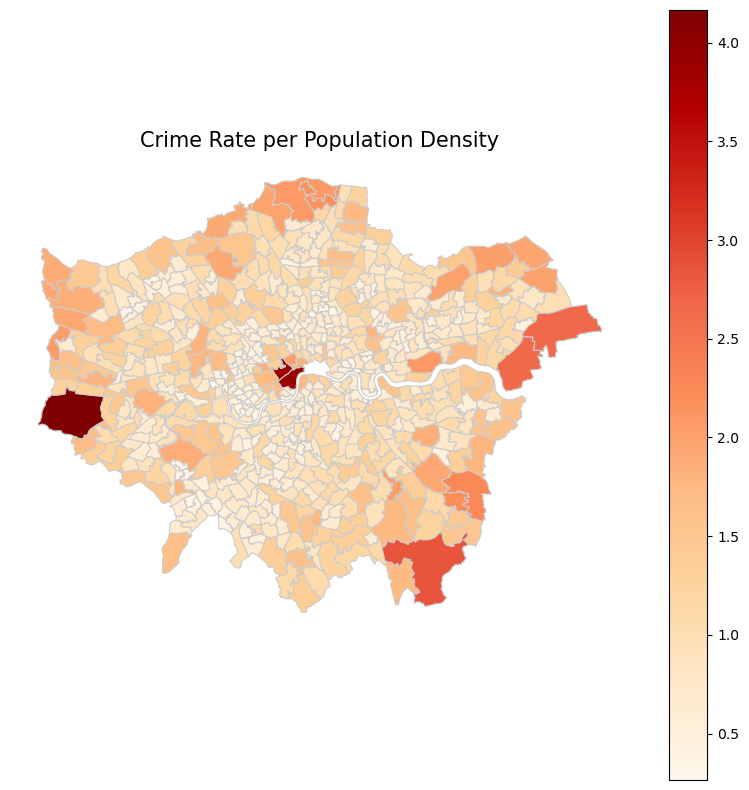

In [3]:
import numpy as np

# Calculate average crime density 
merged_data['crime_per_density'] = merged_data['total_crime'] / merged_data['PopulationDensity']
# Apply logarithmic scaling to the crime data to reduce the skew
merged_data['log_cpr'] = np.log1p(merged_data['crime_per_density'])  # log1p to avoid log(0)
# Plot the weighted crime density
fig, ax = plt.subplots(figsize=(10, 10))
merged_data.plot(column='log_cpr', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

ax.set_title('Crime Rate per Population Density', fontsize=15)
ax.set_axis_off()

plt.show()


### Hotspot Analysis by Kernel Density Estimation (KDE)

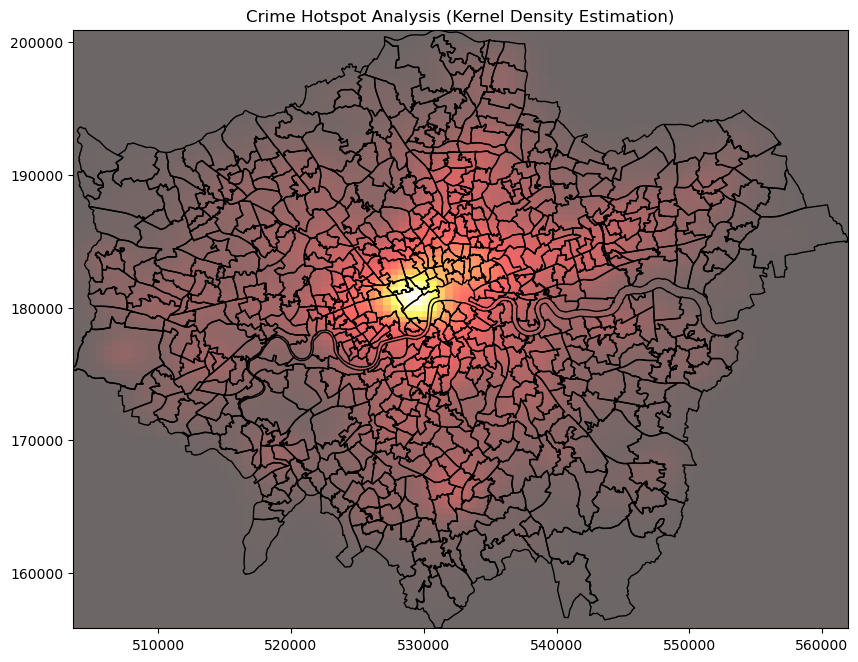

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.stats import gaussian_kde

# Calculate the centroids of the wards
merged_data['centroid'] = merged_data.geometry.centroid
merged_data['x'] = merged_data['centroid'].x
merged_data['y'] = merged_data['centroid'].y

# Prepare the data for KDE
# Use the centroids of the ward geometries and crime data
coords = np.vstack([merged_data['x'], merged_data['y']])
crime_density = merged_data['total_crime'].values

# Compute the kernel density estimate
kde = gaussian_kde(coords, weights=crime_density, bw_method=0.15) 

# Generate grid points for plotting
xmin, ymin, xmax, ymax = merged_data.total_bounds
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
grid_coords = np.vstack([xx.ravel(), yy.ravel()])

# Evaluate KDE on the grid points
crime_density_estimates = kde(grid_coords).reshape(xx.shape)

# Plot the crime density (hotspot)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.rot90(crime_density_estimates), extent=[xmin, xmax, ymin, ymax], cmap='hot', alpha=0.6)
merged_data.plot(ax=ax, facecolor='none', edgecolor='black') 

ax.set_title('Crime Hotspot Analysis (Kernel Density Estimation)')
plt.show()


### Calculating the optimal K for Clustering

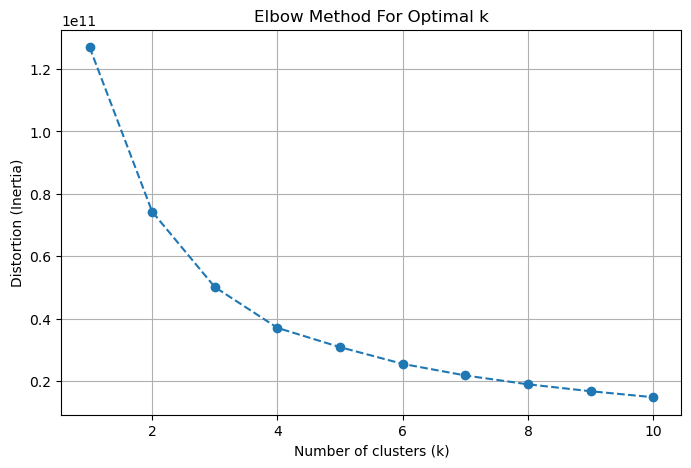

In [5]:
from sklearn.cluster import KMeans

# Prepare the data 
coords = np.vstack([merged_data['x'], merged_data['y']]).T
distortions = []

# Perform K-means clustering for different numbers of clusters (k values)
K_range = range(1, 11)  # Trying k from 1 to 10
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10) 
    kmeans.fit(coords)  # Fit the model
    distortions.append(kmeans.inertia_) 

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, distortions, marker='o', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


### Visualizing Crime Clusters by K Means method

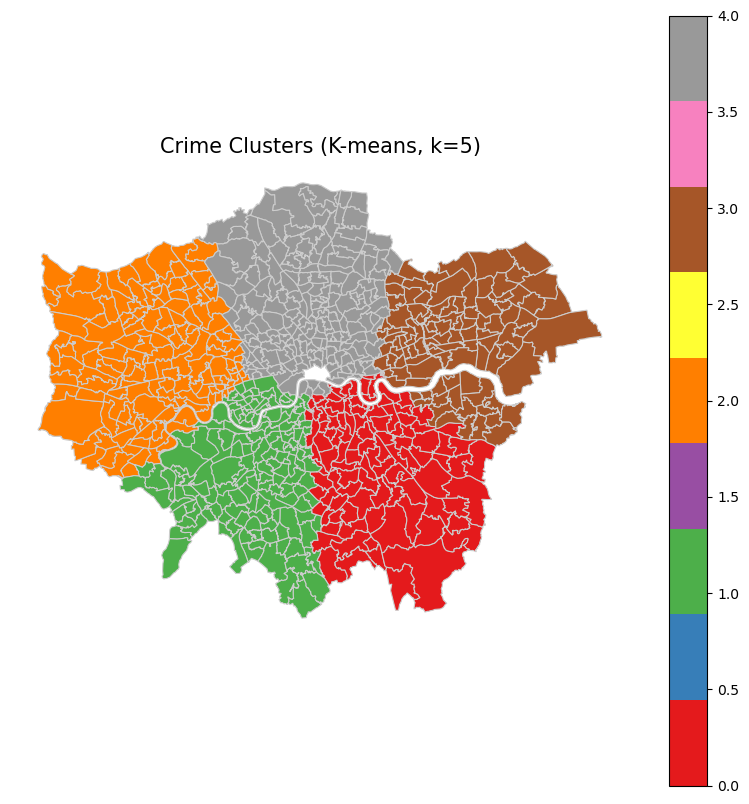

In [6]:
# Based on the elbow plot, let's use k=5 as it seems to be the optimal number of clusters
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, n_init=10)
merged_data['cluster'] = kmeans.fit_predict(coords)

# Visualize the result with the optimal number of clusters
fig, ax = plt.subplots(figsize=(10, 10))
merged_data.plot(column='cluster', cmap='Set1', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title(f'Crime Clusters (K-means, k={optimal_k})', fontsize=15)
ax.set_axis_off()
plt.show()


In [7]:
# Calculate the mean crime count for each cluster
cluster_summary = merged_data.groupby('cluster')['total_crime'].mean()
print(cluster_summary)
cluster_summary = merged_data.groupby('cluster')['total_crime'].agg(['mean', 'median', 'count'])
print(cluster_summary)

cluster
0    11554.933333
1     9931.348993
2    11146.874126
3    11169.901961
4    16849.530387
Name: total_crime, dtype: float64
                 mean   median  count
cluster                              
0        11554.933333  10467.0    105
1         9931.348993   7603.0    149
2        11146.874126   9875.0    143
3        11169.901961  10464.5    102
4        16849.530387  12708.0    181


### BY Agglomerative Clustering 

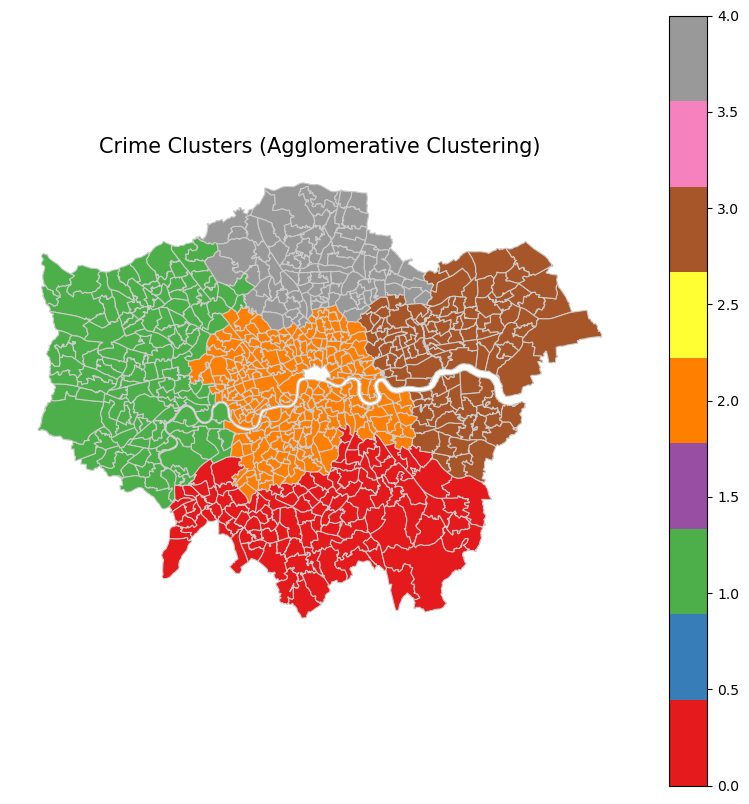

In [8]:
from sklearn.cluster import AgglomerativeClustering

# Prepare the coordinates 
coords = np.vstack([merged_data['x'], merged_data['y']]).T

# Apply Agglomerative Clustering with a specified number of clusters
agglo = AgglomerativeClustering(n_clusters=5)  
merged_data['agglo_cluster'] = agglo.fit_predict(coords)

# Visualize the Agglomerative Clustering result
fig, ax = plt.subplots(figsize=(10, 10))
merged_data.plot(column='agglo_cluster', cmap='Set1', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Crime Clusters (Agglomerative Clustering)', fontsize=15)
ax.set_axis_off()

plt.show()


In [9]:
# Calculate mean total crime for each cluster
cluster_summary = merged_data.groupby('agglo_cluster')['total_crime'].mean()
print(cluster_summary)


agglo_cluster
0     9502.587156
1    10484.570370
2    15695.392405
3    11484.107143
4    11711.609195
Name: total_crime, dtype: float64


### Visualization with Labels for comparison 

K-means Clusters (Mean Total Crime):
kmeans_cluster
0    17032.977528
1    11529.392157
2    11134.503448
3    11221.887755
4     9898.222930
Name: total_crime, dtype: float64
Agglomerative Clusters (Mean Total Crime):
agglo_cluster
0     9502.587156
1    10484.570370
2    15695.392405
3    11484.107143
4    11711.609195
Name: total_crime, dtype: float64


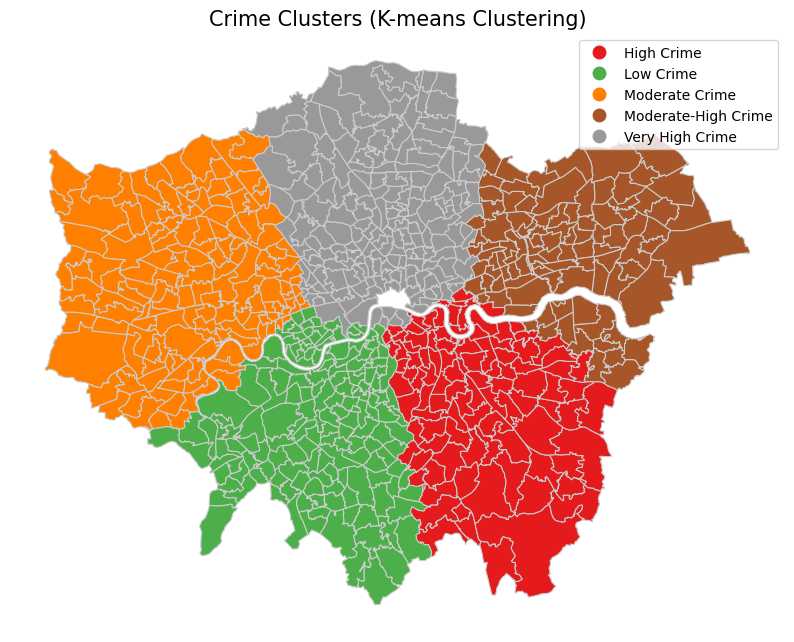

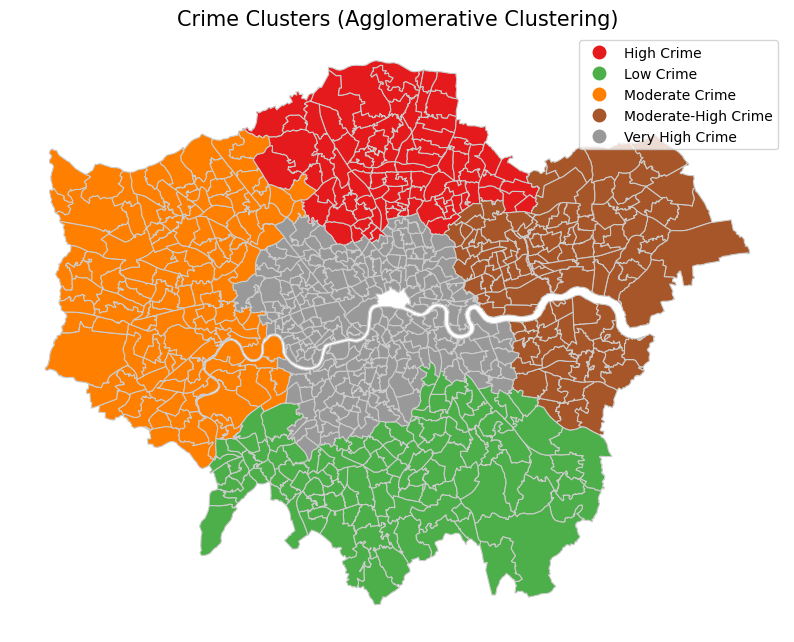

Comparison of Mean Total Crime for K-means and Agglomerative Clustering:

K-means Clusters:
kmeans_cluster
0    17032.977528
1    11529.392157
2    11134.503448
3    11221.887755
4     9898.222930
Name: total_crime, dtype: float64

Agglomerative Clusters:
agglo_cluster
0     9502.587156
1    10484.570370
2    15695.392405
3    11484.107143
4    11711.609195
Name: total_crime, dtype: float64


In [55]:

# Prepare the coordinates 
coords = np.vstack([merged_data['x'], merged_data['y']]).T

# Apply K-means Clustering with 5 clusters
kmeans = KMeans(n_clusters=5, n_init=10)
merged_data['kmeans_cluster'] = kmeans.fit_predict(coords)

# Compute the mean total crime for each K-means cluster
kmeans_cluster_summary = merged_data.groupby('kmeans_cluster')['total_crime'].mean()
print("K-means Clusters (Mean Total Crime):")
print(kmeans_cluster_summary)

# Sort K-means clusters by mean total crime
kmeans_sorted_clusters = kmeans_cluster_summary.sort_values().index
kmeans_labels = {
    kmeans_sorted_clusters[0]: 'Low Crime',
    kmeans_sorted_clusters[1]: 'Moderate Crime',
    kmeans_sorted_clusters[2]: 'Moderate-High Crime',
    kmeans_sorted_clusters[3]: 'High Crime',
    kmeans_sorted_clusters[4]: 'Very High Crime'
}

# Apply labels to K-means clustering results
merged_data['kmeans_cluster_label'] = merged_data['kmeans_cluster'].map(kmeans_labels)


# Apply Agglomerative Clustering with 5 clusters
agglo = AgglomerativeClustering(n_clusters=5)
merged_data['agglo_cluster'] = agglo.fit_predict(coords)

# Compute the mean total crime for each Agglomerative cluster
agglo_cluster_summary = merged_data.groupby('agglo_cluster')['total_crime'].mean()
print("Agglomerative Clusters (Mean Total Crime):")
print(agglo_cluster_summary)

# Sort Agglomerative clusters by mean total crime
agglo_sorted_clusters = agglo_cluster_summary.sort_values().index
agglo_labels = {
    agglo_sorted_clusters[0]: 'Low Crime',
    agglo_sorted_clusters[1]: 'Moderate Crime',
    agglo_sorted_clusters[2]: 'Moderate-High Crime',
    agglo_sorted_clusters[3]: 'High Crime',
    agglo_sorted_clusters[4]: 'Very High Crime'
}

# Apply labels to Agglomerative clustering results
merged_data['agglo_cluster_label'] = merged_data['agglo_cluster'].map(agglo_labels)

### 3. Visualize K-means Clusters ###
fig, ax = plt.subplots(figsize=(10, 10))
merged_data.plot(column='kmeans_cluster_label', cmap='Set1', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Crime Clusters (K-means Clustering)', fontsize=15)
ax.set_axis_off()
plt.show()

### 4. Visualize Agglomerative Clusters ###
fig, ax = plt.subplots(figsize=(10, 10))
merged_data.plot(column='agglo_cluster_label', cmap='Set1', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Crime Clusters (Agglomerative Clustering)', fontsize=15)
ax.set_axis_off()
plt.show()

### 5. Compare Cluster Means ###
print("Comparison of Mean Total Crime for K-means and Agglomerative Clustering:")
print("\nK-means Clusters:")
print(kmeans_cluster_summary)

print("\nAgglomerative Clusters:")
print(agglo_cluster_summary)


## Moran's I test for Spatial Autocorrelation

Moran's I: 0.3297429500738881
p-value: 2.5782290189048967e-46


<Figure size 800x600 with 0 Axes>

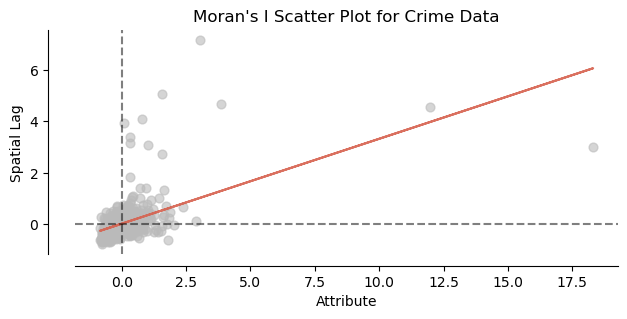

In [11]:
import libpysal
from esda import Moran
from libpysal import weights
import geopandas as gpd


# Ensure the geometry column is in a projected coordinate system
merged_data = merged_data.to_crs(epsg=27700)

### 1. Create Spatial Weights Matrix ###
w = weights.Queen.from_dataframe(merged_data, use_index=True)

# Standardize the weights
w.transform = 'r'

# Extract crime data (total_crime) for Moran's I calculation
crime_data = merged_data['total_crime'].values

# Calculate Moran's I
moran = Moran(crime_data, w)

# Print Moran's I and its p-value
print(f"Moran's I: {moran.I}")
print(f"p-value: {moran.p_norm}")

# Plot Moran's I scatter plot
from splot.esda import moran_scatterplot
plt.figure(figsize=(8, 6))
moran_scatterplot(moran)
plt.title("Moran's I Scatter Plot for Crime Data")
plt.show()


/var/folders/j5/xkk3qpj9129b4_zdxbh59hwm0000gn/T/ipykernel_1575/2671666316.py:10: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(merged_data)


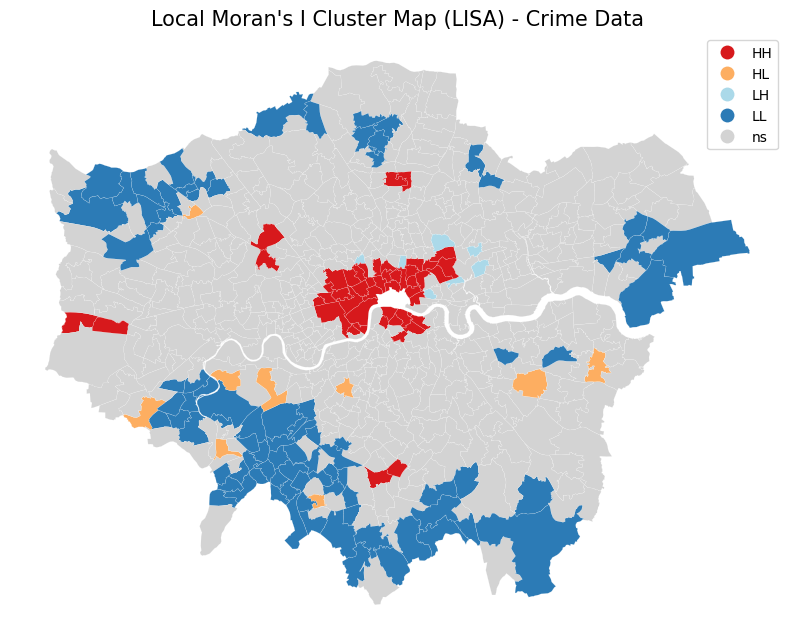

In [12]:
from esda.moran import Moran_Local
from libpysal import weights
from splot.esda import lisa_cluster, plot_local_autocorrelation

# Ensure your geodata is projected to a CRS that works for spatial analysis (e.g., EPSG:27700 for UK)
merged_data = merged_data.to_crs(epsg=27700)

### 1. Create Spatial Weights Matrix ###
# Create a spatial weights matrix based on Queen contiguity (ward neighbors sharing an edge/corner)
w = weights.Queen.from_dataframe(merged_data)
w.transform = 'r'  # Row-standardization

### 2. Calculate Local Moran's I ###
# Extract crime data (total_crime) for Local Moran's I calculation
crime_data = merged_data['total_crime'].values

# Calculate Local Moran's I (LISA)
local_moran = Moran_Local(crime_data, w)

### 3. Add LISA Results to the GeoDataFrame ###
# Add the Local Moran's I values and significant p-values to the dataframe
merged_data['local_moran_I'] = local_moran.Is
merged_data['local_moran_p'] = local_moran.p_sim  # Simulated p-values for significance testing
merged_data['significant'] = merged_data['local_moran_p'] < 0.05  # Mark significant areas
merged_data['quadrant'] = local_moran.q  # Cluster types (high-high, low-low, etc.)

### 4. Visualize Local Moran's I Clusters ###
# Plot Local Moran's I clusters (high-high, low-low, high-low, low-high)
fig, ax = plt.subplots(figsize=(10, 10))
lisa_cluster(local_moran, merged_data, p=0.05, ax=ax)
plt.title("Local Moran's I Cluster Map (LISA) - Crime Data", fontsize=15)
plt.show()


